# Colour - HDRI - Example: Merge from Low Dynamic Range Files

Through this example, some Canon EOS 5D Mark II *CR2* files converted to low dynamic range *sRGB* colourspace *Tiff* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Conversion of the *CR2* files to low dynamic range *sRGB* colourspace *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of a camera response functions computation dedicated image stack using cherry picked *Tiff* files. The two files with lowest luminance are discarded as their contribution is biasing the resulting camera response functions.
    - Reading of the *Tiff* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Computation of the camera response functions.
- Creation of an image stack using *Tiff* files.
- Merging of the image stack into a radiance image using the camera response functions.
- Display of the final resulting radiance image.

In [1]:
%matplotlib inline

In [2]:
import glob
import logging
import numpy as np
import os
import pylab
import shlex
import subprocess

import colour
from colour.plotting import *

from colour_hdri import (
    ImageStack,
    camera_response_function_Debevec1997,
    filter_files,
    radiance_image,
    radiance_image_strip_plot,
    weighting_function_Debevec1997)

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

RESOURCES_DIRECTORY = os.path.join(os.getcwd(), 'resources')

RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

## CR2 Files Conversion to Tiff Files¶

In [3]:
for path in RAW_FILES:
    LOGGER.info('Converting "{0}" to "Tiff" file...'.format(path))
    subprocess.call(['dcraw'] + shlex.split('-w -W -H 0 -q 3 -T "{0}"'.format(file)))

TIFF_FILES = glob.glob('{0}/*.tiff'.format(RESOURCES_DIRECTORY))

INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2602.CR2" to "Tiff" file...


## Camera Response Functions Computation

INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.tiff" image.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.tiff" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.tiff' file exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.tiff" image.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.tiff" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.tiff' file exif data.


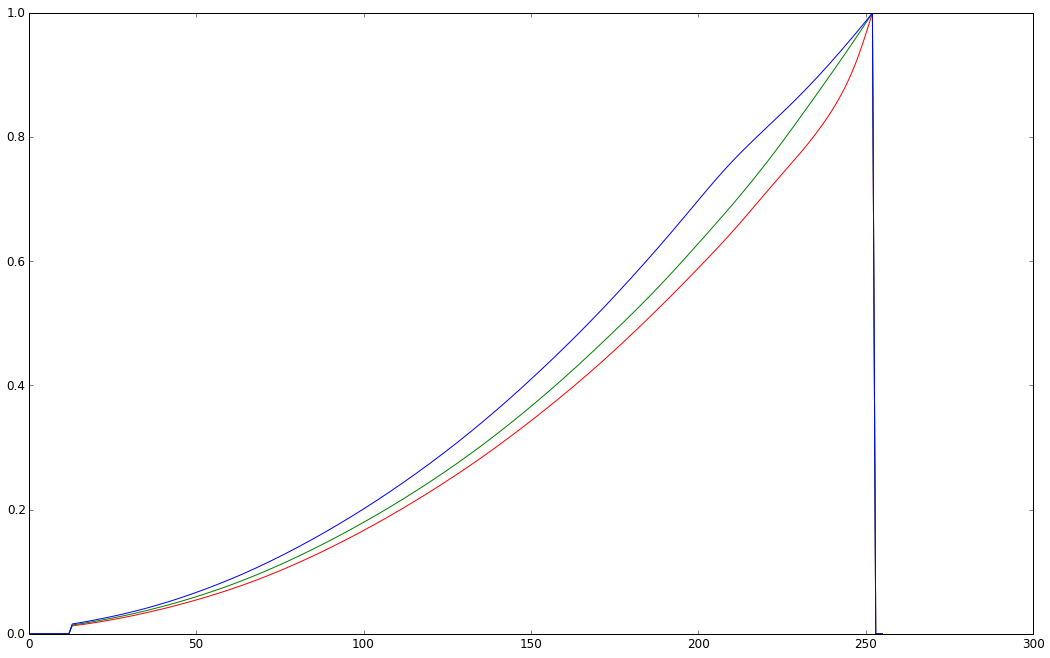

In [4]:
weighting_function_custom = lambda x: weighting_function_Debevec1997(x, 0.05, 0.99)

CRFS = camera_response_function_Debevec1997(
    ImageStack.from_files(TIFF_FILES[2:5]), w=weighting_function_custom)

pylab.plot(CRFS)
pylab.show()

## Radiance Image Merge

In [5]:
def example_merge_from_ldr_files(
        ldr_files,
        output_directory,
        camera_response_functions,
        batch_size=5,
        weighting_function=weighting_function_custom):
    for ldr_files in colour.batch(ldr_files, batch_size):
        image_stack = ImageStack.from_files(ldr_files)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MLF.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))
        
        LOGGER.info('Merging "{0}"...'.format(path))
        LOGGER.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        LOGGER.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        LOGGER.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = radiance_image(image_stack,
                               weighting_function,
                               camera_response_functions=camera_response_functions)
        image[np.isnan(image)] = 0
        
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path

IMAGE, PATH = example_merge_from_ldr_files(TIFF_FILES, RESOURCES_DIRECTORY, CRFS)

INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff" image.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff' file exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.tiff" image.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.tiff" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.tiff' file exif data.


## Radiance Image Display

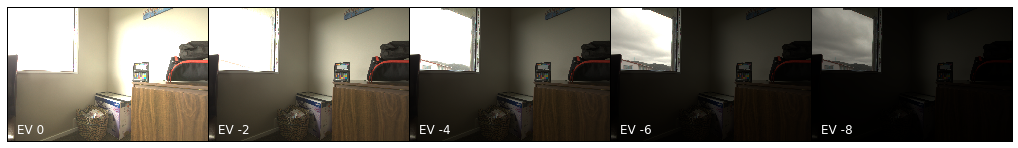

In [6]:
radiance_image_strip_plot(IMAGE)